# Projet d'Analyse de Données de Capteurs pour la Classification d'Exercices

## Description du Projet
Ce projet vise à analyser des données provenant de multiples capteurs (EMG, IMU, IPS, COP, MOCAP) pour classifier différents types d'exercices physiques. Nous utilisons des approches de deep learning, notamment des architectures CNN-LSTM, pour effectuer cette classification.

## Structure du Projet

### 1. Préparation des Données
- Extraction des données depuis des fichiers ZIP
- Standardisation et nettoyage des données
- Organisation des données par capteurs et type d'exercice

### 2. Prétraitement
- Rééchantillonnage des données à 60Hz
- Normalisation des données
- Création de fenêtres glissantes pour l'analyse temporelle

### 3. Modélisation
Nous comparons deux approches :
- Un modèle CNN-LSTM simple
- Un modèle CNN-LSTM multimodal fusionnant les données de tous les capteurs

### 4. Validation
Deux stratégies de validation sont utilisées :
- Split normal (80-20)
- Leave-One-Group-Out (LOGO) pour une validation plus robuste

## 1. Importation des Bibliothèques
Les bibliothèques principales utilisées dans ce projet :
- numpy : pour les calculs numériques
- pandas : pour la manipulation des données
- matplotlib : pour la visualisation
- sklearn : pour le prétraitement et l'évaluation
- tensorflow/keras : pour les modèles de deep learning
- imblearn : pour la gestion du déséquilibre des classes

In [2]:
import os
import re
import zipfile
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import (
    LSTM,
    Concatenate,
    Conv1D,
    Dense,
    Dropout,
    Input,
    MaxPooling1D,
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

## 2. Chargement et Préparation des Données

### 2.1 Extraction des Fichiers
Notre première étape consiste à extraire les données brutes depuis un fichier ZIP. Ces données sont ensuite organisées de manière structurée par capteur et par type d'exercice. Nous mettons en place un système de filtrage pour exclure les fichiers système et autres éléments non pertinents pour notre analyse.

### 2.2 Transposition des Données
Les données brutes nécessitent une restructuration pour être exploitables. Nous effectuons une lecture systématique des fichiers CSV, suivie d'une transposition pour obtenir un format adapté à notre analyse. Cette étape inclut également une standardisation des noms de colonnes pour assurer la cohérence des données.



In [3]:
def transpose_data(input_file):
    # Charge le fichier CSV dans un DataFrame pandas
    data = pd.read_csv(input_file)
    
    # Identifie les colonnes qui ne sont pas numériques ou des chiffres, et les considère comme des clés
    non_numeric_keys = [key for key in data.keys() if not (isinstance(key, (int, float)) or key.isdigit())]
    
    # Renomme la première clé non numérique en 'ID' (clé primaire pour la transposition)
    data = data.rename(columns={non_numeric_keys[0]: 'ID'})
    
    # Définit la colonne 'ID' comme index, puis transpose les données
    data = data.set_index('ID').transpose()
    
    return data

def unzip_and_process_files(zip_file_path, extract_to_folder, ignore_patterns=None):    
    # Vérifie si le fichier ZIP existe
    if not os.path.exists(zip_file_path):
        print(f"Le fichier zip {zip_file_path} n'existe pas.")
        return
    
    # Vérifie si les fichiers sont déjà extraits dans le dossier de destination
    if os.path.exists(extract_to_folder):
        print(f"Le fichier est déjà décompressé dans {extract_to_folder}.")
        return
    
    # Crée le dossier de destination si il n'existe pas
    os.makedirs(extract_to_folder, exist_ok=True)

    # Liste des fichiers à ignorer (par défaut, rien à ignorer)
    if ignore_patterns is None:
        ignore_patterns = []
    
    try:
        # Ouvre le fichier ZIP pour extraction
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Liste tous les fichiers présents dans l'archive ZIP
            zip_files = zip_ref.namelist()

            # Extraire uniquement les fichiers qui ne sont pas dans les fichiers à ignorer
            for file_name in zip_files:
                # Si le fichier correspond à un des patterns à ignorer, on l'ignore
                if any(pattern in file_name for pattern in ignore_patterns):
                    continue  # Ignore ce fichier et passe au suivant
                
                # Si le fichier est un CSV, on applique la transposition
                if file_name.endswith('.csv'):
                    # Extrait le fichier CSV dans le dossier spécifié
                    zip_ref.extract(file_name, extract_to_folder)
                    
                    # Applique la transposition au fichier CSV extrait
                    file_path = os.path.join(extract_to_folder, file_name)
                    transposed_data = transpose_data(file_path)
                    
                    # Sauvegarde le fichier CSV transposé dans le même emplacement
                    transposed_data.to_csv(file_path, index=False)
                    print(f"Fichier transposé et extrait : {file_path}")
            
            # Message indiquant que l'extraction est terminée
            print(f"Extraction terminée dans {extract_to_folder}")
    
    # Gestion des erreurs si le fichier ZIP est invalide
    except zipfile.BadZipFile:
        print(f"Erreur : Le fichier {zip_file_path} n'est pas un fichier zip valide.")
    except Exception as e:
        # Capture d'autres erreurs
        print(f"Erreur lors de la décompression : {e}")

# Paramètres du fichier ZIP et du dossier de destination
zip_file_path = 'dataset.zip'
extract_to_folder = 'unprocessed_datasets' 

# Liste des fichiers à ignorer pendant l'extraction
ignore_patterns = ['.txt', '_MACOSX', '.DS_Store']

# Appel de la fonction pour décompresser et traiter les fichiers
unzip_and_process_files(zip_file_path, extract_to_folder, ignore_patterns)


Le fichier est déjà décompressé dans unprocessed_datasets.


### 2.3 Structure des Données

Notre jeu de données comprend des enregistrements de plusieurs patients réalisant différents types d'exercices. 

Les données sont collectées via divers capteurs, chacun ayant sa propre fréquence d'échantillonnage. 

Cette diversité des sources d'information enrichit notre analyse tout en présentant des défis d'harmonisation.


#### 2.3.1 Énumérage des fichiers

Nous faisons un parcours de tous les fichiers dans le dossier unprocessed_datasets et enregistrons les chemins de chaque fichier dans une liste.

In [4]:
def extract_number_from_path(path):
    # Utiliser une expression régulière pour extraire le premier nombre dans le chemin
    match = re.search(r'\\(\d+)', path)  # Cherche un nombre qui suit un backslash
    if match:
        return int(match.group(1))  # Retourne le nombre trouvé en tant qu'entier
    return 0  # Si aucun nombre n'est trouvé, on retourne 0

def get_files_paths(directory_path):
    files_paths = []  # Liste pour stocker les chemins des fichiers trouvés
    
    # Parcourir les fichiers dans le répertoire et ses sous-répertoires
    for root, dir, files in os.walk(directory_path):
        for file_name in files:
            # Ajouter le chemin complet du fichier à la liste
            files_paths.append(os.path.join(root, file_name))

    return files_paths

# Utiliser la fonction pour obtenir tous les chemins des fichiers dans 'unprocessed_datasets'
# Trier les chemins de fichiers selon le premier nombre trouvé dans chaque chemin (en utilisant 'extract_number_from_path')
UNPROCESSED_FILES_PATH = sorted(get_files_paths('unprocessed_datasets'), key=extract_number_from_path)


#### 2.3.2 Extraction du Numéro de Patient

Nous faisons un parcours de tous les fichiers dans le dossier unprocessed_datasets et enregistrons les numéros de patient dans un ensemble.

In [5]:
def get_number_of_patient(files_paths):
    # Utiliser un ensemble (set) pour garder les numéros de patient uniques
    patient_numbers = set()

    # Parcourir les chemins de fichiers
    for file_path in files_paths:
        # Extraire le numéro de patient (le second élément du chemin)
        # On suppose que le numéro de patient est situé dans la deuxième position du chemin
        # par exemple : 'unprocessed_datasets\\1\\exercice\\sensor.csv'
        patient_number = file_path.split('\\')[1]
        
        # Ajouter le numéro de patient à l'ensemble
        # L'ensemble garantit l'unicité des numéros de patient
        patient_numbers.add(patient_number)

    # Retourner le nombre de patients uniques
    # La longueur de l'ensemble correspond au nombre de patients distincts
    return len(patient_numbers)

# Appel de la fonction pour obtenir le nombre de patients uniques à partir des chemins de fichiers
SAMPLE_SIZE = get_number_of_patient(UNPROCESSED_FILES_PATH)

# Afficher le nombre de patients
print(f"Nombre de patients : {SAMPLE_SIZE}")

Nombre de patients : 25


#### 2.3.3 Extraction du Type d'Exercice

Nous faisons un parcours de tous les fichiers dans le dossier unprocessed_datasets et enregistrons les types d'exercices dans un ensemble.


In [6]:
def get_exercice_type(files_paths):
    # Créer un ensemble pour stocker les types d'exercices uniques
    exercice_type = set()

    # Parcourir les chemins de fichiers
    for file_path in files_paths:
        # Extraire le numéro du patient à partir du chemin
        patient_number = file_path.split('\\')[1]
        
        # Si le numéro du patient n'est pas '1', on arrête la boucle
        if patient_number != '1':
            break 
        
        # Extraire le nom de l'exercice, qui se trouve dans le troisième élément du chemin
        exercice_name = file_path.split('\\')[2]
        
        # Ajouter le nom de l'exercice à l'ensemble
        exercice_type.add(exercice_name)

    # Retourner l'ensemble des types d'exercices uniques
    return exercice_type

# Obtenir les types d'exercices pour le patient '1' à partir de la liste des chemins de fichiers
EXERCICES_TYPE = get_exercice_type(UNPROCESSED_FILES_PATH)

# Afficher les types d'exercices extraits
print(f"Types d'exercices : {EXERCICES_TYPE}")


Types d'exercices : {'still', 'forward', 'back', 'halfsquat'}


#### 2.3.4 Extraction du Type de Capteur et de la Fréquence d'Échantillonnage

Nous faisons un parcours de tous les fichiers dans le dossier unprocessed_datasets et enregistrons les types de capteurs dans un dictionnaire.

De plus, nous estimons la fréquence d'échantillonnage du capteur à partir de la durée de l'exercice.


In [7]:
def estimate_sampling_rate_from_duration(file_path, duration_seconds):
    # Lire le fichier CSV
    data = pd.read_csv(file_path)
    
    # Nombre d'échantillons dans le fichier
    num_samples = data.shape[0]
    
    # Estimer la fréquence d'échantillonnage : nombre d'échantillons / durée en secondes
    sampling_rate = round(num_samples / duration_seconds / 10) * 10
    
    # Retourner la fréquence d'échantillonnage estimée
    return round(sampling_rate)

def get_sensors_type_and_sampling_rate(files_paths):
    # Dictionnaire pour stocker les types de capteurs et leurs fréquences d'échantillonnage
    SENSORS_TYPE = {}
    
    # Durée des enregistrements, utilisée pour estimer la fréquence d'échantillonnage
    DURATION = 66.1  # Durée en secondes, par exemple 66.1 secondes pour chaque fichier

    # Parcourir les chemins des fichiers
    for file_path in files_paths:
        # Extraire le numéro du patient à partir du chemin
        patient_number = file_path.split('\\')[1]
        
        # Si le numéro du patient n'est pas '1', ignorer ce fichier
        if patient_number != '1':
            break  # Si on a traité le patient '1', on arrête l'analyse des autres patients
        
        # Extraire le nom du capteur à partir du chemin du fichier
        sensor_name = file_path.split('\\')[3].split('_')[0].replace('.csv', '')
        
        # Estimer la fréquence d'échantillonnage pour ce capteur
        sensor_rate = estimate_sampling_rate_from_duration(file_path, DURATION)
        
        # Ajouter le capteur et sa fréquence d'échantillonnage au dictionnaire si ce capteur n'existe pas déjà
        if sensor_name not in SENSORS_TYPE:
            SENSORS_TYPE[sensor_name] = sensor_rate

    # Retourner le dictionnaire des types de capteurs et leurs fréquences d'échantillonnage
    return SENSORS_TYPE

# Obtenir les types de capteurs et leurs fréquences d'échantillonnage
SENSORS_TYPE = get_sensors_type_and_sampling_rate(UNPROCESSED_FILES_PATH)

print("Types de capteurs détectés et leurs fréquences d'échantillonnage : ", SENSORS_TYPE)


Types de capteurs détectés et leurs fréquences d'échantillonnage :  {'cop': 60, 'emg': 2000, 'imu': 100, 'ips': 60, 'mocap': 100}


## 3. Prétraitement des Données

### 3.1 Analyse Initiale des Données
Notre première étape consiste en une analyse approfondie des données brutes. 

Cette exploration nous a permis d'identifier plusieurs caractéristiques importantes de notre jeu de données. Nous avons notamment constaté que les capteurs fonctionnent à des fréquences d'échantillonnage différentes, allant de 60Hz à 200Hz selon le type de capteur. 

Les enregistrements suivent une durée standardisée, bien que certains fichiers contiennent plusieurs sessions d'enregistrement, identifiées par des suffixes (_1, _2, _3).

Nous avons également repéré la présence de valeurs manquantes et de bruit dans les signaux, nécessitant un traitement particulier.

### 3.2 Nettoyage des Données
Le nettoyage des données constitue une étape fondamentale de notre prétraitement.

Nous commençons par fusionner les enregistrements multiples d'un même exercice pour obtenir des séquences complètes et cohérentes.

Les fichiers temporaires et les doublons sont ensuite supprimés pour éviter toute redondance.

Les valeurs aberrantes, identifiées par des analyses statistiques, sont éliminées, tandis que les valeurs manquantes sont comblées par interpolation linéaire pour maintenir la continuité des signaux.


In [8]:
# Parcours de tous les chemins de fichiers dans la liste UNPROCESSED_FILES_PATH
for file_path in UNPROCESSED_FILES_PATH:
    
    # Si le fichier contient '_1' dans son nom
    if('_1' in file_path):
        # Lire le fichier CSV et sauvegarder sous un nouveau nom sans '_1'
        pd.read_csv(file_path).to_csv(file_path.replace('_1',''), index=False)
        
        # Supprimer l'ancien fichier avec '_1' dans son nom
        os.remove(file_path)
        
    # Si le fichier contient '_2' dans son nom
    if('_2' in file_path):
        # Lire les données de deux fichiers, l'un avec '_2' et l'autre sans '_2'
        data_1 = pd.read_csv(file_path.replace('_2',''))  # Fichier sans '_2'
        data_2 = pd.read_csv(file_path)  # Fichier avec '_2'
        
        # Fusionner les deux ensembles de données
        pd.concat([data_1, data_2]).to_csv(file_path.replace('_2',''), index=False)
        
        # Supprimer l'ancien fichier avec '_2' dans son nom
        os.remove(file_path)
        
    # Si le fichier contient '_3' dans son nom
    if('_3' in file_path):
        # Lire les données de deux fichiers, l'un avec '_3' et l'autre sans '_3'
        data_1 = pd.read_csv(file_path.replace('_3',''))  # Fichier sans '_3'
        data_2 = pd.read_csv(file_path)  # Fichier avec '_3'
        
        # Fusionner les deux ensembles de données
        pd.concat([data_1, data_2]).to_csv(file_path.replace('_3',''), index=False)
        
        # Supprimer l'ancien fichier avec '_3' dans son nom
        os.remove(file_path)


Nous supprimons les suffixes '_1', '_2' et '_3' de la liste des fichiers et supprimons les doublons.

In [9]:
def remove_suffix_and_duplicates(file_names):   
    # Liste qui contiendra les noms de fichiers nettoyés
    cleaned_files = []
    
    # Set utilisé pour garder une trace des fichiers déjà rencontrés
    seen = set()

    # Ce pattern capture tout avant un underscore suivi d'un chiffre (_n) et l'extension du fichier
    pattern = re.compile(r"(.*?)(_\d+)?\.[^\.]+$")  # Exemple : "file_1.csv" => "file"
    
    for file in file_names:
        # Appliquer l'expression régulière pour extraire la partie avant '_n' et l'extension
        match = pattern.match(file)
        
        if match:
            base_name = match.group(1)  # On récupère le nom de base sans le suffixe _n
            if base_name not in seen:
                # Si le fichier n'a pas encore été rencontré, on le garde dans la liste
                cleaned_files.append(file.replace('_1', ''))  # Enlève le suffixe '_1'
                seen.add(base_name)  # On ajoute le nom de base au set 'seen' pour éviter les doublons
        else:
            # Si le fichier ne correspond pas au pattern (ex. pas de suffixe '_n'), on l'ajoute tel quel
            cleaned_files.append(file.replace('_1', ''))  # On enlève '_1' s'il est présent
            seen.add(file)  # Ajout du fichier complet au set 'seen'

    # Retourne la liste des fichiers nettoyés, sans doublons
    return cleaned_files

# Appliquer cette fonction à la liste des fichiers non traités
UNPROCESSED_FILES_PATH = remove_suffix_and_duplicates(UNPROCESSED_FILES_PATH)

### 3.3 Rééchantillonnage
L'harmonisation des fréquences d'échantillonnage représente un défi majeur de notre prétraitement. 

Nous avons choisi de standardiser toutes nos données à 60Hz, correspondant à la fréquence la plus basse parmi nos capteurs.

Cette transformation est réalisée par interpolation linéaire, permettant de préserver au mieux la dynamique des signaux.

Une attention particulière est portée à la vérification de la cohérence temporelle après rééchantillonnage.

In [10]:
def resampling(dataset_wrong_frequency, dataset_desired_frequency, wrong_frequency, desired_frequency, debug=False):
    # Si les fréquences sont déjà égales, on renvoie simplement le dataset original sans modification
    if wrong_frequency == desired_frequency:
        return dataset_wrong_frequency
    
    # Création d'un DataFrame avec une nouvelle colonne 'time' pour les données avec une fréquence incorrecte
    df_wrong_Hz = dataset_wrong_frequency
    sampling_rate_wrong_Hz = wrong_frequency
    # Crée une série de temps basée sur la fréquence d'échantillonnage initiale (en microsecondes)
    df_wrong_Hz['time'] = pd.date_range(start='00:00:00', periods=df_wrong_Hz.shape[0], freq=f'{int(1e6 / sampling_rate_wrong_Hz)}us')

    # Nombre de points dans les données à la fréquence erronée
    n_points_wrong_Hz = len(df_wrong_Hz)
    
    # Nombre de points dans les données à la fréquence désirée
    n_points_desired_Hz = dataset_desired_frequency.shape[0]

    # Crée une série de temps avec la fréquence désirée
    time = pd.date_range(start=df_wrong_Hz['time'].iloc[0], periods=n_points_desired_Hz, freq=f'{int(desired_frequency/10)}ms')
    
    # Définit la colonne 'time' comme index
    df_wrong_Hz.set_index('time', inplace=True)
    
    # Rééchantillonne les données à la fréquence désirée en réindexant et en interpolant les valeurs manquantes
    df_wrong_Hz_resampled = df_wrong_Hz.reindex(time).interpolate(method='linear')

    # Si le mode debug est activé, affiche des informations sur le rééchantillonnage
    if debug == True:
        print(f"Nombre de points à {wrong_frequency} Hz avant interpolation:", n_points_wrong_Hz)
        print(f"Nombre de points à {desired_frequency} Hz après interpolation:", len(df_wrong_Hz_resampled))
    
    return df_wrong_Hz_resampled

Ici nous créons un ensemble de sous-données.

Chaque sous-donnée est stockée dans le dossier processed_datasets et est rééchantillonnée à 60Hz.

In [11]:
# Création du dossier processed_datasets si ce n'est pas déjà fait
if not os.path.exists('processed_datasets'):
    os.makedirs('processed_datasets')

# Processus de rééchantillonnage pour chaque fichier non traité
for file_path in UNPROCESSED_FILES_PATH:
    # Chemin vers le dossier des fichiers traités
    PROCESSED_FILES_PATH = os.path.dirname(file_path.replace('unprocessed_datasets', 'processed_datasets'))
    
    # Si le dossier n'existe pas, le créer
    if not os.path.exists(PROCESSED_FILES_PATH):
        os.makedirs(PROCESSED_FILES_PATH)
    
    # Nom du capteur, extrait du chemin du fichier
    sensor_name = file_path.split('\\')[3].split('_')[0].replace('.csv','')
    
    # Fréquence de mesure du capteur (définie dans un dictionnaire global SENSORS_TYPE)
    sensor_rate = SENSORS_TYPE[sensor_name]
    
    # Si le fichier traité n'existe pas déjà
    if not os.path.exists(f'{PROCESSED_FILES_PATH}/{sensor_name}.csv'):
        # Applique le rééchantillonnage des données à 60 Hz (en utilisant un autre fichier comme référence)
        processed_data = resampling(pd.read_csv(file_path), pd.read_csv('unprocessed_datasets\\1\\back\\cop.csv'), sensor_rate, 60, debug=True)
        
        # Sauvegarde les données rééchantillonnées dans le dossier des fichiers traités
        processed_data.to_csv(f'{PROCESSED_FILES_PATH}/{sensor_name}.csv', index=False)
        
        # Affiche un message indiquant le rééchantillonnage
        print(f'{PROCESSED_FILES_PATH}/{sensor_name}.csv est passé de {sensor_rate} Hz à 60Hz')


### 3.4 Structuration des Données
Notre approche de validation nécessite deux organisations distinctes des données.

La première, que nous appelons "Split Normal", suit une répartition classique 80-20 entre données d'entraînement et de test. 

La seconde, plus rigoureuse, utilise une validation de type "Leave-One-Group-Out" (LOGO), où nous réservons les données de cinq patients pour le test, tandis que les vingt autres servent à l'entraînement. 

Cette double approche nous permettra d'évaluer la robustesse de nos modèles.


Ici nous récupérons le chemin des fichiers traités et nous les ajoutons dans une liste.

In [12]:
PROCESSED_FILES_PATH = sorted(get_files_paths('processed_datasets'), key=extract_number_from_path)

#### 3.4.1 Normal Split

Nous créons un ensemble de données, qui se répartit en 80% d'entraînement et 20% de test, à l'aide des fichiers traités.

Nous créons un dossier normal_split si ce n'est pas déjà fait dans lequel nous créons un fichier pour chaque capteur.

Ensuite, nous concaténons les données de chaque patient pour ce capteur et nous ajoutons une colonne label qui contient le type d'exercice.

Enfin, nous sauvegardons les données dans le dossier normal_split.

In [13]:
if not os.path.exists('normal_split'):
    os.makedirs('normal_split')

for sensor in SENSORS_TYPE:
    if  os.path.exists(f'normal_split/{sensor}.csv'):
         print(f'normal_split/{sensor}.csv existe déjà')
         continue
    print(f'normal_split/{sensor}.csv en cours de création')
    df = pd.DataFrame()
    for exercice in EXERCICES_TYPE:
            
            for i in range(1,SAMPLE_SIZE+1):
                try:
                    data = pd.read_csv(f'processed_datasets/{i}/{exercice}/{sensor}.csv')
                    data["label"] = exercice
                    df = pd.concat([df, data], axis=0).reset_index(drop=True)
                except:
                    continue
            df.to_csv(f'normal_split/{sensor}.csv',index=False)
    print(f'normal_split/{sensor}.csv créé')        


normal_split/cop.csv existe déjà
normal_split/emg.csv existe déjà
normal_split/imu.csv existe déjà
normal_split/ips.csv existe déjà
normal_split/mocap.csv existe déjà


#### 3.4.2 LOGO Split

Nous créons un ensemble de données, qui se répartit en 20 patients pour l'entraînement et 5 patients pour le test, à l'aide des fichiers traités.

Nous créons un dossier logo_split si ce n'est pas déjà fait dans lequel nous créons un fichier pour chaque capteur.

Ensuite, nous concaténons les données de chaque patient pour ce capteur et nous ajoutons une colonne label qui contient le type d'exercice.

Nous ajoutons également une colonne patient qui contient le numéro du patient.

Enfin, nous sauvegardons les données dans le dossier logo_split.

In [14]:
if not os.path.exists('logo_split'):
    os.makedirs('logo_split')

for sensor in SENSORS_TYPE:
    if  os.path.exists(f'logo_split/{sensor}.csv'):
         print(f'logo_split/{sensor}.csv existe déjà')
         continue
    print(f'logo_split/{sensor}.csv en cours de création')
    df = pd.DataFrame()
    for exercice in EXERCICES_TYPE:
            
            for i in range(1,SAMPLE_SIZE+1):
                try:
                    data = pd.read_csv(f'processed_datasets/{i}/{exercice}/{sensor}.csv')
                    data["label"] = exercice
                    data["patient"] = i
                    df = pd.concat([df, data], axis=0).reset_index(drop=True)
                except:
                    continue
            df.to_csv(f'logo_split/{sensor}.csv',index=False)
    print(f'logo_split/{sensor}.csv créé')        


logo_split/cop.csv existe déjà
logo_split/emg.csv existe déjà
logo_split/imu.csv existe déjà
logo_split/ips.csv existe déjà
logo_split/mocap.csv existe déjà


### 3.5 Gestion de l'Équilibrage des Classes

L'équilibrage des classes représente un aspect crucial de notre prétraitement.

#### 3.5.1 Vérification des classes des datasets
Nous créons un tableau pour le nombre de mesures par exercice et par capteur pour le Normal Split et le LOGO Split.


In [16]:
number_of_measures_normal = pd.DataFrame(columns=list(EXERCICES_TYPE), index=list(SENSORS_TYPE.keys()))
number_of_measures_logo = pd.DataFrame(columns=list(EXERCICES_TYPE), index=list(SENSORS_TYPE.keys()))

for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        normal_data = pd.read_csv(f"normal_split/{sensor}.csv")
        logo_data = pd.read_csv(f"logo_split/{sensor}.csv")
        number_of_measures_normal.loc[sensor,exercice] = normal_data[normal_data['label'] == exercice].shape[0]
        number_of_measures_logo.loc[sensor,exercice] = logo_data[logo_data['label'] == exercice].shape[0]

Tableau du nombre de mesures par exercice et par capteur :


,still,forward,back,halfsquat
cop,100000,100000,100000,100000
emg,100000,100000,100000,100000
imu,100000,100000,100000,100000
ips,100000,100000,100000,100000
mocap,100000,100000,100000,100000


In [22]:
number_of_measures_normal

,still,forward,back,halfsquat
cop,100000,100000,100000,100000
emg,100000,100000,100000,100000
imu,100000,100000,100000,100000
ips,100000,100000,100000,100000
mocap,100000,100000,100000,100000


In [23]:
number_of_measures_logo

,still,forward,back,halfsquat
cop,100000,100000,100000,100000
emg,100000,100000,100000,100000
imu,100000,100000,100000,100000
ips,100000,100000,100000,100000
mocap,100000,100000,100000,100000


Puis nous affichons le nombre de mesures par exercice et par capteur pour le Normal Split et le LOGO Split.


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (5, 4).

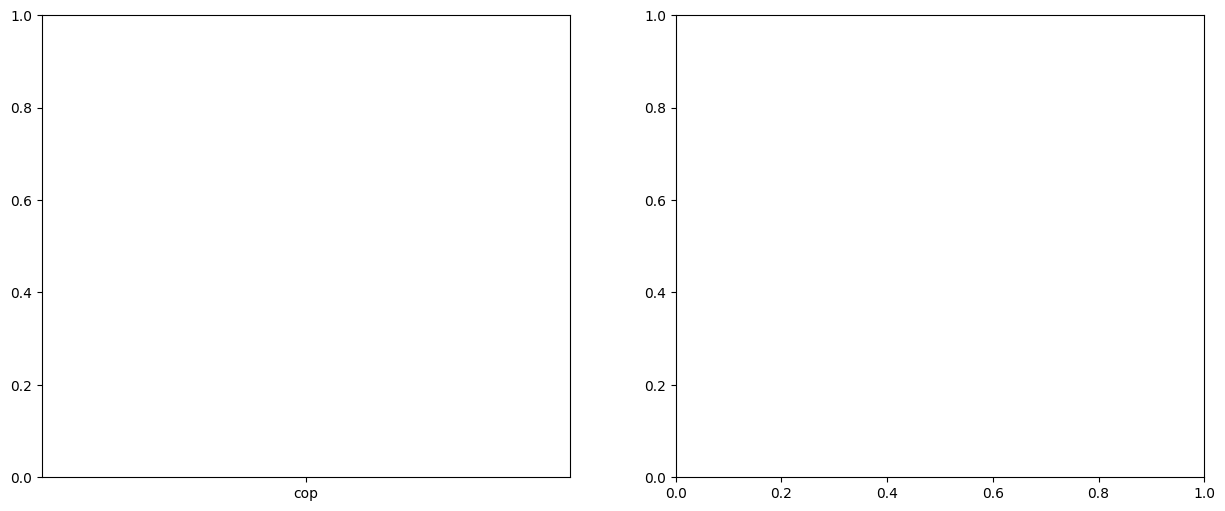

In [21]:
# Plot settings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # 1 ligne, 2 colonnes

# Graphique 1: Mesures Normal
ax1.bar(number_of_measures_normal.index, number_of_measures_normal.values, color='skyblue')
ax1.set_xlabel("Type de capteur", fontsize=12)
ax1.set_ylabel("Nombre de mesures", fontsize=12)
ax1.set_title("Mesures Normal", fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

# Graphique 2: Mesures Logo
ax2.bar(number_of_measures_logo.index, number_of_measures_logo.values, color='lightgreen')
ax2.set_xlabel("Type de capteur", fontsize=12)
ax2.set_ylabel("Nombre de mesures", fontsize=12)
ax2.set_title("Mesures Logo", fontsize=14)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

# Ajuster les espacements pour éviter le chevauchement
plt.tight_layout()

# Afficher les graphiques
plt.show()

Notre analyse initiale ayant révélé des déséquilibres dans la représentation des différents exercices, nous utilisons une combinaison de techniques de sur-échantillonnage (SMOTE) et de sous-échantillonnage pour obtenir des classes équilibrées.

Cette étape est particulièrement importante pour éviter les biais dans l'apprentissage de nos modèles.

In [17]:
NORMAL_SPLIT_FILES_PATH = sorted(get_files_paths('normal_split'), key=extract_number_from_path)

In [18]:
def check_class_balance(y, target_count=100000):
    """Vérifie si la distribution des classes est équilibrée après rééchantillonnage"""
    class_counts = y.value_counts()
    balanced = all(count == target_count for count in class_counts)
    if not balanced:
        print(f"Classes are not balanced. Current class distribution: {class_counts}")
    return balanced

def resample_and_check(file_path, max_attempts=3):
    df = pd.read_csv(file_path)

    df.dropna(inplace=True)

    attempts = 0
    while attempts < max_attempts:
        # Séparation des caractéristiques et des labels
        X = df.drop(columns=['label'])
        y = df['label']
        
        # Vérification de la distribution des classes actuelles
        current_class_counts = y.value_counts()
        print(f"Initial class distribution for {file_path}: {current_class_counts}")
        if X.shape[0] != 400000:
            print(f"Before SMOTE or Under-Sampling to {file_path}, attempt {attempts + 1}")
            print(X.shape, y.shape)
            
            # Appliquer un RandomUnderSampler uniquement si une classe a plus d'échantillons que la cible
            if any(current_class_counts[exercice] > 100000 for exercice in EXERCICES_TYPE):
                current_class_counts[exercice]
                print("Applying Random Under-Sampling due to over-represented classes")
                sampling_strategy = {exercice: min(100000, current_class_counts[exercice]) for exercice in EXERCICES_TYPE}
                under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
                X_resampled, y_resampled = under_sampler.fit_resample(X, y)
                print(f"After under-sampling, class distribution: {pd.Series(y_resampled).value_counts()}")
                balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                        pd.DataFrame({'label': y_resampled})], axis=1)
                # Sauvegarder le DataFrame rééchantillonné dans un nouveau fichier CSV
                df = balanced_df
            else:
                # Appliquer SMOTE en ajustant la stratégie de rééchantillonnage
                sampling_strategy = {exercice: 100000 for exercice in EXERCICES_TYPE}
                smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
                X_resampled, y_resampled = smote.fit_resample(X, y)
                balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                        pd.DataFrame({'label': y_resampled})], axis=1)
                # Sauvegarder le DataFrame rééchantillonné dans un nouveau fichier CSV
                df = balanced_df
                print(f"After SMOTE, class distribution: {pd.Series(y_resampled).value_counts()}")

            # Vérification de l'équilibre des classes après rééchantillonnage
            if check_class_balance(y_resampled):
                balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                        pd.DataFrame({'label': y_resampled})], axis=1)
                # Sauvegarder le DataFrame rééchantillonné dans un nouveau fichier CSV
                balanced_df.to_csv(file_path, index=False)
                print(f"Successfully balanced and saved {file_path}")
                break
            else:
                print(f"Warning: Classes are still not balanced in {file_path} after attempt {attempts + 1}")
                
        else:
            print(f"Already balanced {file_path}")
            break

        attempts += 1
        if attempts >= max_attempts:
            print(f"Max attempts reached for {file_path}. Consider adjusting strategy or target count.")

# Appel de la fonction pour chaque fichier
for file_path in NORMAL_SPLIT_FILES_PATH:
    resample_and_check(file_path)


Initial class distribution for normal_split\cop.csv: label
back         100000
still        100000
forward      100000
halfsquat    100000
Name: count, dtype: int64
Already balanced normal_split\cop.csv
Initial class distribution for normal_split\emg.csv: label
back         100000
still        100000
forward      100000
halfsquat    100000
Name: count, dtype: int64
Already balanced normal_split\emg.csv
Initial class distribution for normal_split\imu.csv: label
back         100000
still        100000
forward      100000
halfsquat    100000
Name: count, dtype: int64
Already balanced normal_split\imu.csv
Initial class distribution for normal_split\ips.csv: label
back         100000
still        100000
forward      100000
halfsquat    100000
Name: count, dtype: int64
Already balanced normal_split\ips.csv
Initial class distribution for normal_split\mocap.csv: label
back         100000
still        100000
forward      100000
halfsquat    100000
Name: count, dtype: int64
Already balanced norm

In [19]:
for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        data = pd.read_csv(f"normal_split/{sensor}.csv")
        number_of_measures.loc[sensor,exercice] = data[data['label'] == exercice].shape[0]

In [20]:
number_of_measures

,back,forward,still,halfsquat
cop,100000,100000,100000,100000
emg,100000,100000,100000,100000
imu,100000,100000,100000,100000
ips,100000,100000,100000,100000
mocap,100000,100000,100000,100000


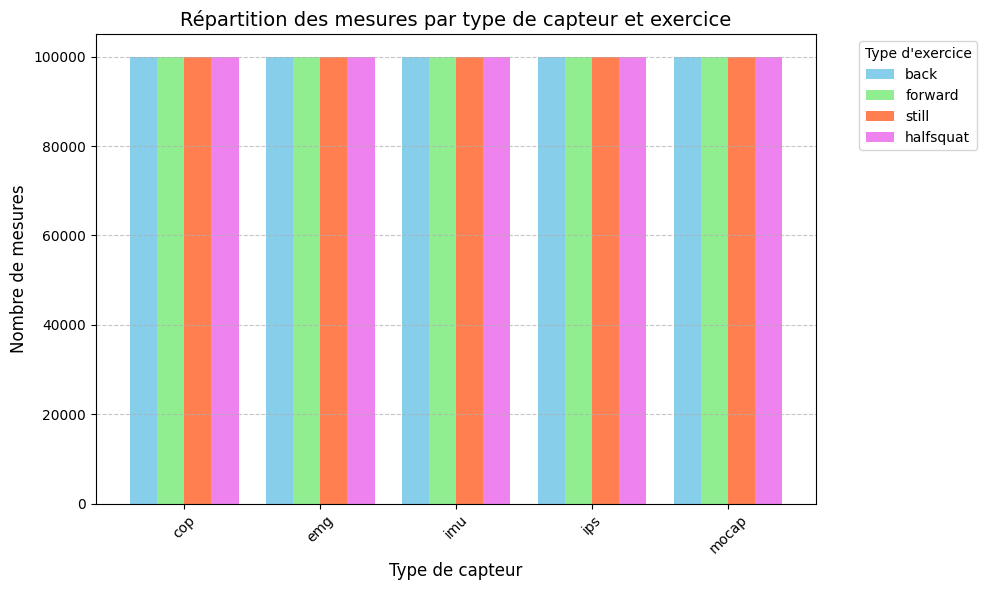

In [21]:
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting grouped bars
number_of_measures.plot(kind='bar', ax=ax, width=0.8, color=['skyblue', 'lightgreen', 'coral', 'violet', 'gold'])

# Customize axes
ax.set_xlabel("Type de capteur", fontsize=12)
ax.set_ylabel("Nombre de mesures", fontsize=12)
ax.set_title("Répartition des mesures par type de capteur et exercice", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x', rotation=45)

# Add legend
ax.legend(title="Type d'exercice", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

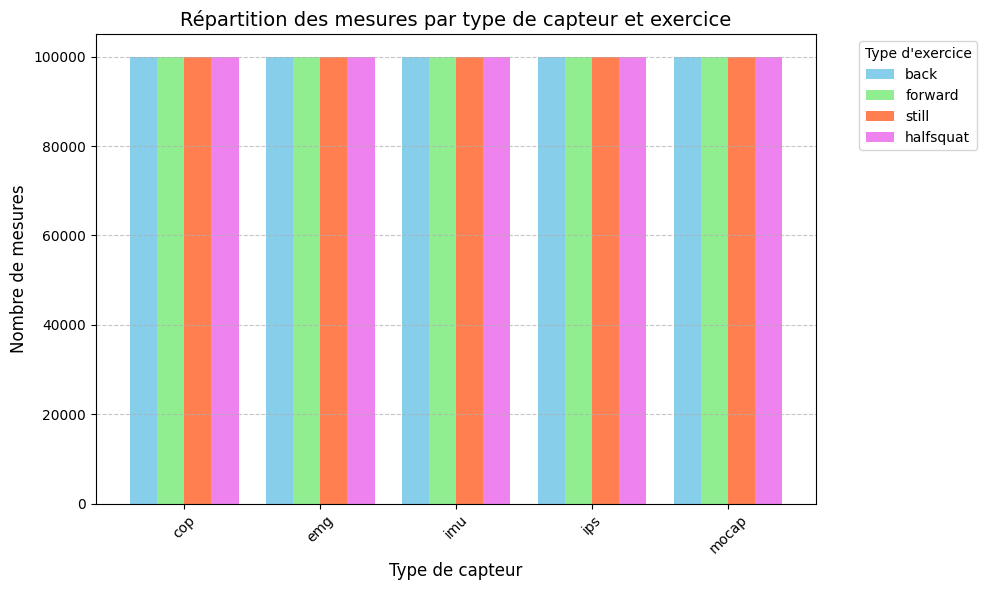

In [25]:
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting grouped bars
number_of_measures.plot(kind='bar', ax=ax, width=0.8, color=['skyblue', 'lightgreen', 'coral', 'violet', 'gold'])

# Customize axes
ax.set_xlabel("Type de capteur", fontsize=12)
ax.set_ylabel("Nombre de mesures", fontsize=12)
ax.set_title("Répartition des mesures par type de capteur et exercice", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x', rotation=45)

# Add legend
ax.legend(title="Type d'exercice", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [26]:
LOGO_SPLIT_FILES_PATH = sorted(get_files_paths('logo_split'), key=extract_number_from_path)

In [28]:
sampling_strategy = {}
for exercice in EXERCICES_TYPE:
    sampling_strategy[exercice] = 100000  # Nombre cible d'échantillons pour chaque classe

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

for file_path in LOGO_SPLIT_FILES_PATH:
    df = pd.read_csv(file_path)

    df.dropna(inplace=True)
    # Séparation des caractéristiques et des labels
    X = df.drop(columns=['label','patient'])  # Caractéristiques
    y = df['label']  # Labels
    z = df['patient']
        
    # Vérification de la distribution des classes actuelles
    current_class_counts = y.value_counts()

    if(X.shape[0] != 400000):
        
        print(f"Before SMOTE or Under-Sampling to {file_path}")
        print(X.shape, y.shape)
        # Appliquer un RandomUnderSampler uniquement si une classe a plus d'échantillons que la cible
        if any(current_class_counts[exercice] > 100000 for exercice in EXERCICES_TYPE):
            print("Applying Random Under-Sampling due to over-represented classes")
            # Sous-échantillonnage : ne réduire qu'à la taille cible (pas plus)
            undersample_strategy = {exercice: min(current_class_counts[exercice], 100000) for exercice in EXERCICES_TYPE}
            under_sampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
            X_resampled, y_resampled = under_sampler.fit_resample(X, y)
        else:
            # Appliquer SMOTE pour équilibrer les classes (ajouter des échantillons)
            X_resampled, y_resampled = smote.fit_resample(X, y)

        print(f"After SMOTE or Under-Sampling to {file_path}")
        print(X_resampled.shape, y_resampled.shape)

        # Combinaison des caractéristiques et des labels dans un nouveau DataFrame
        """balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
        balanced_df['label'] = y_resampled
        balanced_df['patient'] = z"""
        balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                             pd.DataFrame({'label': y_resampled}), 
                             pd.DataFrame({'patient': z.iloc[:len(y_resampled)]})], axis=1)

        # Sauvegarder le DataFrame rééchantillonné dans un nouveau fichier CSV
        balanced_df.to_csv(file_path, index=False)
    else:
        print(f"Already balanced {file_path}")


Already balanced logo_split\cop.csv
Already balanced logo_split\emg.csv
Already balanced logo_split\imu.csv
Already balanced logo_split\ips.csv
Already balanced logo_split\mocap.csv


In [29]:
def check_class_balance_LOGO(y, target_count=100000):
    """Vérifie si la distribution des classes est équilibrée après rééchantillonnage"""
    class_counts = y.value_counts()
    balanced = all(count == target_count for count in class_counts)
    if not balanced:
        print(f"Classes are not balanced. Current class distribution: {class_counts}")
    return balanced

def resample_and_check_LOGO(file_path, max_attempts=3):
    df = pd.read_csv(file_path)
    df.dropna(inplace=True)
    attempts = 0
    while attempts < max_attempts:
        X = df.drop(columns=['label','patient'])  # Caractéristiques
        y = df['label']  # Labels
        z = df['patient']
        
        # Vérification de la distribution des classes actuelles
        current_class_counts = y.value_counts()
        print(f"Initial class distribution for {file_path}: {current_class_counts}")
        if X.shape[0] != 400000:
            print(f"Before SMOTE or Under-Sampling to {file_path}, attempt {attempts + 1}")
            print(X.shape, y.shape)
            
            # Appliquer un RandomUnderSampler uniquement si une classe a plus d'échantillons que la cible
            if any(current_class_counts[exercice] > 100000 for exercice in EXERCICES_TYPE):
                print("Applying Random Under-Sampling due to over-represented classes")
                sampling_strategy = {exercice: min(100000, current_class_counts[exercice]) for exercice in EXERCICES_TYPE}
                under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
                X_resampled, y_resampled = under_sampler.fit_resample(X, y)
                print(f"After under-sampling, class distribution: {pd.Series(y_resampled).value_counts()}")
                balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                    pd.DataFrame({'label': y_resampled}), 
                                    pd.DataFrame({'patient': z.iloc[:len(y_resampled)]})], axis=1)
                # Sauvegarder le DataFrame rééchantillonné dans un nouveau fichier CSV
                balanced_df.dropna(inplace=True)
                df = balanced_df
            else:
                # Appliquer SMOTE en ajustant la stratégie de rééchantillonnage
                sampling_strategy = {exercice: 100000 for exercice in EXERCICES_TYPE}
                smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
                X_resampled, y_resampled = smote.fit_resample(X, y)
                balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                    pd.DataFrame({'label': y_resampled}), 
                                    pd.DataFrame({'patient': z.iloc[:len(y_resampled)]})], axis=1)
                # Sauvegarder le DataFrame rééchantillonné dans un nouveau fichier CSV
                
                df = balanced_df
                print(f"After SMOTE, class distribution: {pd.Series(y_resampled).value_counts()}")

            # Vérification de l'équilibre des classes après rééchantillonnage
            if check_class_balance_LOGO(y_resampled):
                balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                    pd.DataFrame({'label': y_resampled}), 
                                    pd.DataFrame({'patient': z})], axis=1)
                balanced_df['patient']=balanced_df['patient'].apply(lambda x: np.random.randint(1, 26) if pd.isna(x) else x)
                # Sauvegarder le DataFrame rééchantillonné dans un nouveau fichier CSV
                balanced_df.to_csv(file_path, index=False)
                print(f"Successfully balanced and saved {file_path}")
                break
            else:
                print(f"Warning: Classes are still not balanced in {file_path} after attempt {attempts + 1}")
                
        else:
            print(f"Already balanced {file_path}")
            break

        attempts += 1
        if attempts >= max_attempts:
            print(f"Max attempts reached for {file_path}. Consider adjusting strategy or target count.")

# Appel de la fonction pour chaque fichier
for file_path in LOGO_SPLIT_FILES_PATH:
    resample_and_check_LOGO(file_path)

Initial class distribution for logo_split\cop.csv: label
back         100000
still        100000
forward      100000
halfsquat    100000
Name: count, dtype: int64
Already balanced logo_split\cop.csv
Initial class distribution for logo_split\emg.csv: label
back         100000
still        100000
forward      100000
halfsquat    100000
Name: count, dtype: int64
Already balanced logo_split\emg.csv
Initial class distribution for logo_split\imu.csv: label
back         100000
still        100000
forward      100000
halfsquat    100000
Name: count, dtype: int64
Already balanced logo_split\imu.csv
Initial class distribution for logo_split\ips.csv: label
back         100000
still        100000
forward      100000
halfsquat    100000
Name: count, dtype: int64
Already balanced logo_split\ips.csv
Initial class distribution for logo_split\mocap.csv: label
back         100000
still        100000
forward      100000
halfsquat    100000
Name: count, dtype: int64
Already balanced logo_split\mocap.csv


In [30]:
number_of_measures = pd.DataFrame(columns=list(EXERCICES_TYPE), index=list(SENSORS_TYPE.keys()))

for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        data = pd.read_csv(f"logo_split/{sensor}.csv")
        number_of_measures.loc[sensor,exercice] = data[data['label'] == exercice].shape[0]
        
number_of_measures

,back,forward,still,halfsquat
cop,100000,100000,100000,100000
emg,100000,100000,100000,100000
imu,100000,100000,100000,100000
ips,100000,100000,100000,100000
mocap,100000,100000,100000,100000


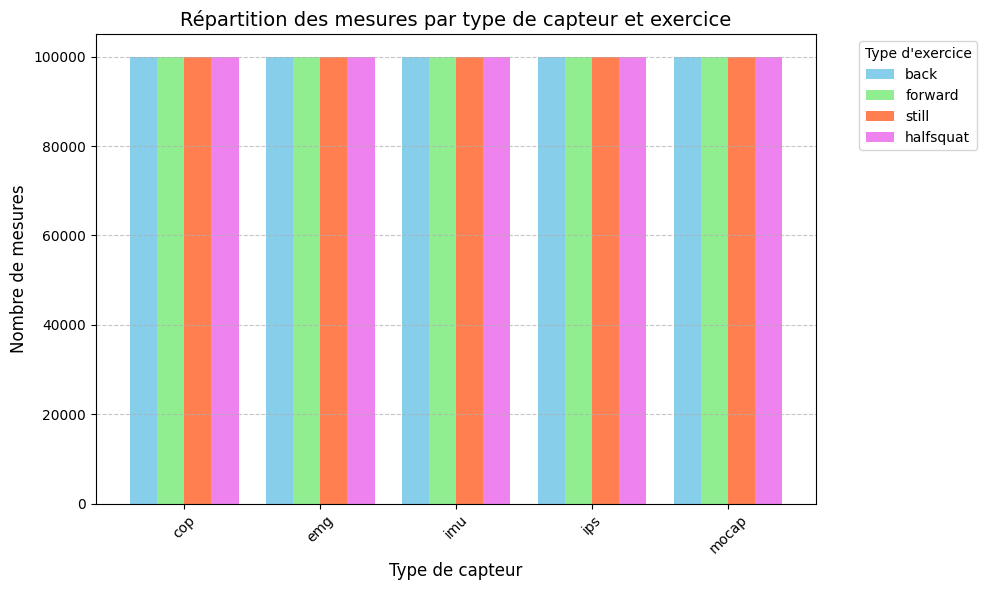

In [31]:
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting grouped bars
number_of_measures.plot(kind='bar', ax=ax, width=0.8, color=['skyblue', 'lightgreen', 'coral', 'violet', 'gold'])

# Customize axes
ax.set_xlabel("Type de capteur", fontsize=12)
ax.set_ylabel("Nombre de mesures", fontsize=12)
ax.set_title("Répartition des mesures par type de capteur et exercice", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x', rotation=45)

# Add legend
ax.legend(title="Type d'exercice", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [32]:
combined_df = pd.DataFrame()
for sensor in SENSORS_TYPE:
    data = pd.read_csv(f"normal_split/{sensor}.csv")
    combined_df.drop(columns=['label'], inplace=True,errors='ignore')
    combined_df = pd.concat([combined_df, data], axis=1)

In [33]:
combined_df.head()

,L_force,R_force,L_cop_x,L_cop_y,R_cop_x,R_cop_y,L_cop_col,L_cop_row,R_cop_col,R_cop_row,...,L_LM_x,L_LM_y,L_LM_z,L_CAL_x,L_CAL_y,L_CAL_z,L_MH1_x,L_MH1_y,L_MH1_z,label
0,385.722931,368.974528,0.277456,0.230076,0.291530,-0.159558,6.75,17.64,7.09,15.42,...,0.230230,0.230522,0.097288,0.175458,0.150199,0.038634,0.427124,0.295456,0.044493,back
1,387.392499,368.974528,0.277516,0.230162,0.291143,-0.159280,6.76,17.63,7.09,15.48,...,0.230636,0.230396,0.097194,0.175447,0.150202,0.038628,0.427110,0.295449,0.044485,back
2,385.331901,369.809312,0.277359,0.230143,0.290983,-0.159174,6.77,17.64,7.09,15.50,...,0.231041,0.230270,0.097100,0.175436,0.150206,0.038622,0.427097,0.295442,0.044477,back
3,386.566502,370.644096,0.277437,0.230299,0.290776,-0.159280,6.77,17.65,7.10,15.48,...,0.231447,0.230144,0.097007,0.175424,0.150209,0.038616,0.427083,0.295434,0.044470,back
4,386.975107,369.809312,0.277420,0.230290,0.290915,-0.159359,6.77,17.65,7.09,15.46,...,0.231853,0.230018,0.096913,0.175413,0.150212,0.038610,0.427069,0.295427,0.044462,back


In [34]:
def create_windows(data, window_size, step_size):
    """
    Crée des fenêtres glissantes à partir des données.
    :param data: array-like, données à segmenter
    :param window_size: int, taille de la fenêtre (en nombre d'échantillons)
    :param step_size: int, pas de la fenêtre (en nombre d'échantillons)
    :return: X (données segmentées), y (étiquettes correspondantes)
    """
    windows = []
    labels = []

    # Découper les données en fenêtres glissantes
    for start in range(0, len(data) - window_size, step_size):
        end = start + window_size
        window = data[start:end].drop('label', axis=1)  # Exclure la colonne 'label'
        windows.append(window[:-1])

        # L'étiquette correspond à la classe à partir du centre de la fenêtre
        # Cela suppose que l'étiquette correspond à la fenêtre entière
        labels.append(data.iloc[end - 1]['label'])  # Utiliser l'étiquette à la fin de la fenêtre
    
    # Convertir en arrays numpy pour Keras
    X = np.array(windows)  # Exclure la dernière fenêtre pour éviter les problèmes de dimensions
    y = np.array(labels)

    return X, y

In [35]:
# Paramètres de la fenêtre
window_size = 60  # Taille de la fenêtre (60 échantillons pour 1 seconde)
step_size = 60  # Pas de la fenêtre (60 échantillons pour pas de chevauchement)

# Segmenter les données en fenêtres
X, y = create_windows(combined_df, window_size, step_size)

# Affichage des dimensions des données segmentées
print(f'X shape: {X.shape}, y shape: {y.shape}')

X shape: (6666, 59, 840), y shape: (6666,)


In [36]:
# Normalisation des données sur chaque fenêtre
scaler = StandardScaler()

# Appliquer la normalisation sur chaque fenêtre (chaque "fenêtre" dans X)
X_scaled = np.array([scaler.fit_transform(window) for window in X])


label_encoder = LabelEncoder()

# Encodage des labels en one-hot
y_encoded = to_categorical(label_encoder.fit_transform(y), num_classes=4)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')


X_train shape: (5332, 59, 840), X_test shape: (1334, 59, 840)


In [37]:
# Fonction pour créer le modèle CNN-LSTM
def create_cnn_lstm_model(input_shape, filters=32, kernel_size=3, lstm_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(Conv1D(filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))  # 4 classes à prédire
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Encapsuler le modèle dans KerasClassifier pour l'utiliser avec GridSearchCV
model = KerasClassifier(build_fn=create_cnn_lstm_model, input_shape=X_train.shape[1:], epochs=10, batch_size=32, verbose=0)

# Définir la grille des hyperparamètres à tester
param_grid = {
    'batch_size': [16, 32],
    'epochs': [5, 10]
}

# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Résultats de la recherche
print(f"Meilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleur score: {grid_search.best_score_}")


C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model``

Meilleurs paramètres: {'batch_size': 16, 'epochs': 10}
Meilleur score: 0.8599042592945437


In [38]:
# Créer le modèle CNN-LSTM
cnn_lstm_model = create_cnn_lstm_model(X_train.shape[1:3])

# Entraîner le modèle
history_cnn_lstm_normal = cnn_lstm_model.fit(X_train, y_train, epochs=grid_search.best_params_['epochs'], batch_size=grid_search.best_params_['batch_size'], validation_data=(X_test, y_test))

# Évaluer les performances sur l'ensemble de test
score_cnn_lstm_normal = cnn_lstm_model.evaluate(X_test, y_test)
print(f"Score du modèle CNN-LSTM : {score_cnn_lstm_normal}")


Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4050 - loss: 1.2896 - val_accuracy: 0.6582 - val_loss: 0.8653
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6706 - loss: 0.9264 - val_accuracy: 0.7204 - val_loss: 0.7232
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7786 - loss: 0.6381 - val_accuracy: 0.7669 - val_loss: 0.6236
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8160 - loss: 0.5066 - val_accuracy: 0.7849 - val_loss: 0.6072
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8484 - loss: 0.3965 - val_accuracy: 0.8088 - val_loss: 0.5632
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8799 - loss: 0.3263 - val_accuracy: 0.8163 - val_loss: 0.5979
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8960 - loss: 0.2841 - val_accuracy: 0.8321 - val_loss: 0.5348
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9295 - loss: 0.1969 - val_accuracy

In [39]:


# Paramètres de la fenêtre
window_size = 60  # Taille de la fenêtre (60 échantillons pour 1 seconde)
step_size = 60  # Pas de la fenêtre (60 échantillons pour pas de chevauchement)

X_ips, y = create_windows(pd.read_csv("normal_split/ips.csv"), window_size, step_size)
X_emg, y = create_windows(pd.read_csv("normal_split/emg.csv"), window_size, step_size)
X_imu, y = create_windows(pd.read_csv("normal_split/imu.csv"), window_size, step_size)
X_cop, y = create_windows(pd.read_csv("normal_split/cop.csv"), window_size, step_size)
X_mocap, y = create_windows(pd.read_csv("normal_split/mocap.csv"), window_size, step_size)

# Normalisation pour chaque modalité (EMG, IMU, IPS)
scaler = StandardScaler()

# Normaliser les données EMG et IMU sur chaque fenêtre (chaque "fenêtre" dans X_emg et X_imu)
X_emg_scaled = np.array([scaler.fit_transform(window) for window in X_emg])
X_imu_scaled = np.array([scaler.fit_transform(window) for window in X_imu])
X_ips_scaled = np.array([scaler.fit_transform(window) for window in X_ips])
X_cop_scaled = np.array([scaler.fit_transform(window) for window in X_cop])
X_mocap_scaled = np.array([scaler.fit_transform(window) for window in X_mocap])


In [40]:
label_encoder = LabelEncoder()
y_encoded = to_categorical(label_encoder.fit_transform(y), num_classes=4)

In [41]:


# Diviser les données en ensembles d'entraînement et de test (80% - 20%)
X_emg_train, X_emg_test, X_imu_train, X_imu_test, X_cop_train,X_cop_test,X_mocap_train,X_mocap_test,X_ips_train, X_ips_test, y_train, y_test = train_test_split(
    X_emg_scaled, X_imu_scaled,X_cop_scaled,X_mocap_scaled, X_ips_scaled, y_encoded, test_size=0.2, random_state=42
)

In [42]:
input_shapes = [
    X_emg_train.shape[1:3],
    X_imu_train.shape[1:3],
    X_ips_train.shape[1:3],
    X_cop_train.shape[1:3],
    X_mocap_train.shape[1:3],
]

print(input_shapes)

[(59, 16), (59, 54), (59, 682), (59, 10), (59, 78)]


In [43]:


# Architecture CNN-LSTM multimodale
def create_cnn_lstm_multimodal_model(input_shapes):
    # Sous-modèle EMG (ici on suppose que c'est une séquence temporelle, donc on utilise un CNN-LSTM)
    emg_input = Input(shape=input_shapes[0], name='emg_input')
    emg_conv1D = Conv1D(32, kernel_size=3, activation='relu')(emg_input)
    emg_maxPooling1D = MaxPooling1D(pool_size=2)(emg_conv1D)
    emg_dropout = Dropout(0.2)(emg_maxPooling1D)
    emg_lstm = LSTM(64, activation='relu', return_sequences=False)(emg_dropout)
    emg_dense = Dropout(0.2)(emg_lstm)
    
    # Sous-modèle IMU (si c'est aussi une séquence temporelle, appliquer CNN-LSTM ici aussi)
    imu_input = Input(shape=input_shapes[1], name='imu_input')
    imu_conv1D = Conv1D(32, kernel_size=3, activation='relu')(imu_input)
    imu_maxPooling1D = MaxPooling1D(pool_size=2)(imu_conv1D)
    imu_dropout = Dropout(0.2)(imu_maxPooling1D)
    imu_lstm = LSTM(64, activation='relu', return_sequences=False)(imu_dropout)
    imu_dense = Dropout(0.2)(imu_lstm)

    # Sous-modèle IPS (données non séquentielles, on utilise des couches denses simples)
    ips_input = Input(shape=input_shapes[2], name='ips_input')
    ips_conv1D = Conv1D(32, kernel_size=3, activation='relu')(ips_input)
    ips_maxPooling1D = MaxPooling1D(pool_size=2)(ips_conv1D)
    ips_dropout = Dropout(0.2)(ips_maxPooling1D)
    ips_lstm = LSTM(64, activation='relu', return_sequences=False)(ips_dropout)
    ips_dense = Dropout(0.2)(ips_lstm)

    # Sous-modèle COP
    cop_input = Input(shape=input_shapes[3], name='cop_input')
    cop_conv1D = Conv1D(32, kernel_size=3, activation='relu')(cop_input)
    cop_maxPooling1D = MaxPooling1D(pool_size=2)(cop_conv1D)
    cop_dropout = Dropout(0.2)(cop_maxPooling1D)
    cop_lstm = LSTM(64, activation='relu', return_sequences=False)(cop_dropout)
    cop_dense = Dropout(0.2)(cop_lstm)

    # Sous-modèle MOCAP
    mocap_input = Input(shape=input_shapes[4], name='mocap_input')
    mocap_conv1D = Conv1D(32, kernel_size=3, activation='relu')(mocap_input)
    mocap_maxPooling1D = MaxPooling1D(pool_size=2)(mocap_conv1D)
    mocap_dropout = Dropout(0.2)(mocap_maxPooling1D)
    mocap_lstm = LSTM(64, activation='relu', return_sequences=False)(mocap_dropout)
    mocap_dense = Dropout(0.2)(mocap_lstm)

    # Fusion des sorties (EMG, IMU, IPS, COP, MOCAP)
    concatenated = Concatenate()([emg_dense, imu_dense, ips_dense, cop_dense, mocap_dense])

    # Couche dense après fusion
    dense = Dense(64, activation='relu')(concatenated)
    dense = Dropout(0.2)(dense)

    # Couche de sortie
    output = Dense(4, activation='softmax')(dense)  # 4 classes à prédire

    # Création du modèle final
    model = Model(inputs=[emg_input, imu_input, ips_input, cop_input, mocap_input], outputs=output)

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [44]:
cnn_lstm_multimodal_model = create_cnn_lstm_multimodal_model(input_shapes)

In [45]:
# Entraînement du modèle multimodal CNN-LSTM
history_cnn_lstm_multimodal_normal = cnn_lstm_multimodal_model.fit(
    [X_emg_train, X_imu_train, X_ips_train,X_cop_train,X_mocap_train], y_train,
    batch_size=32,
    epochs=10,
    validation_data=([X_emg_test, X_imu_test, X_ips_test,X_cop_test,X_mocap_test], y_test)
)

Epoch 1/10


C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['emg_input', 'imu_input', 'ips_input', 'cop_input', 'mocap_input']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4430 - loss: 1.3199 - val_accuracy: 0.7076 - val_loss: 0.8789
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7317 - loss: 0.7508 - val_accuracy: 0.7931 - val_loss: 0.5565
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8320 - loss: 0.4741 - val_accuracy: 0.8546 - val_loss: 0.4138
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8698 - loss: 0.3678 - val_accuracy: 0.8868 - val_loss: 0.3230
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9136 - loss: 0.2437 - val_accuracy: 0.9018 - val_loss: 0.2746
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9288 - loss: 0.2145 - val_accuracy: 0.9048 - val_loss: 0.3352
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9485 - loss: 0.1527 - val_accuracy: 0.9258 - val_loss: 0.2468
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9510 - loss: 0.1504 - val_accuracy: 0.922

In [46]:
score_cnn_lstm_multimodal_normal = cnn_lstm_multimodal_model.evaluate([X_emg_train, X_imu_train, X_ips_train,X_cop_train,X_mocap_train], y_train)
print(f"Score du modèle CNN-LSTM : {score_cnn_lstm_multimodal_normal}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9606 - loss: 0.1074
Score du modèle CNN-LSTM : [0.10541727393865585, 0.9619280099868774]


In [47]:
# Afficher le résumé du modèle
cnn_lstm_multimodal_model.summary()

Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ emg_input           │ (None, 59, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imu_input           │ (None, 59, 54)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ips_input           │ (None, 59, 682)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cop_input           │ (None, 59, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mocap_input         │ (None, 59, 78)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 57, 32)    │      1,568 │ emg_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 57, 32)    │      5,216 │ imu_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 57, 32)    │     65,504 │ ips_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 57, 32)    │        992 │ cop_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 57, 32)    │      7,520 │ mocap_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 28, 32)    │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 28, 32)    │          0 │ conv1d_15[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 28, 32)    │          0 │ conv1d_16[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 28, 32)    │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 28, 32)    │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 28, 32)    │          0 │ max_pooling1d_14… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 28, 32)    │          0 │ max_pooling1d_15… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 28, 32)    │          0 │ max_pooling1d_16… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 677,294 (2.58 MB)

 Trainable params: 225,764 (881.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 451,530 (1.72 MB)

In [48]:
# ------------------------ Code for CNN-LSTM ------------------------
# Prédictions sur l'ensemble de test pour CNN-LSTM
y_pred_cnn_lstm_normal = np.argmax(cnn_lstm_model.predict(X_test), axis=-1)

# Si y_test est one-hot encodé, convertir y_test en labels d'indices entiers
y_test_labels_normal = np.argmax(y_test, axis=-1)

# Générer un rapport de classification pour CNN-LSTM
report_cnn_lstm_normal = classification_report(y_test_labels_normal, y_pred_cnn_lstm_normal, target_names=label_encoder.classes_, output_dict=True)


# Matrice de confusion pour CNN-LSTM
conf_matrix_cnn_lstm_normal= confusion_matrix(y_test_labels_normal, y_pred_cnn_lstm_normal)

# ------------------------ Code for Multimodal CNN-LSTM ------------------------
# Prédictions sur l'ensemble de test pour le modèle multimodal CNN-LSTM
predictions_multimodal_normal = cnn_lstm_multimodal_model.predict([X_emg_test, X_imu_test, X_ips_test, X_cop_test, X_mocap_test])

y_pred_multimodal_normal = np.argmax(predictions_multimodal_normal, axis=-1)

# Générer un rapport de classification pour le modèle multimodal CNN-LSTM
report_multimodal_normal = classification_report(y_test_labels_normal, y_pred_multimodal_normal, target_names=label_encoder.classes_, output_dict=True)

# Matrice de confusion pour le modèle multimodal CNN-LSTM
conf_matrix_multimodal_normal = confusion_matrix(y_test_labels_normal, y_pred_multimodal_normal)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['emg_input', 'imu_input', 'ips_input', 'cop_input', 'mocap_input']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [49]:
combined_df = pd.DataFrame()
for sensor in SENSORS_TYPE:
    data = pd.read_csv(f"logo_split/{sensor}.csv")
    combined_df.drop(columns=['label'], inplace=True,errors='ignore')
    combined_df.drop(columns=['patient'], inplace=True,errors='ignore')
    combined_df = pd.concat([combined_df, data], axis=1)

In [50]:
def create_windows(data, window_size, step_size):
    """
    Crée des fenêtres glissantes à partir des données.
    :param data: DataFrame, données à segmenter
    :param window_size: int, taille de la fenêtre (en nombre d'échantillons)
    :param step_size: int, pas de la fenêtre (en nombre d'échantillons)
    :return: X (données segmentées), y (étiquettes correspondantes)
    """
    windows = []
    labels = []

    # Découper les données en fenêtres glissantes
    for start in range(0, len(data) - window_size, step_size):
        end = start + window_size
        window = data[start:end].drop('label', axis=1)  # Exclure la colonne 'label'
        windows.append(window[:-1])

        # L'étiquette correspond à la classe à partir du centre de la fenêtre
        labels.append(data.iloc[end - 1]['label'])  # Utiliser l'étiquette à la fin de la fenêtre
    
    # Convertir en arrays numpy pour Keras
    X = np.array(windows)  # Exclure la dernière fenêtre pour éviter les problèmes de dimensions
    y = np.array(labels)

    return X, y

# Paramètres de la fenêtre
window_size = 60  # Taille de la fenêtre (60 échantillons pour 1 seconde)
step_size = 60  # Pas de la fenêtre (60 échantillons pour pas de chevauchement)

# Supposons que combined_df soit déjà votre DataFrame
# Identifiez les 25 patients uniques
patients = combined_df['patient'].unique()

# Diviser les patients en ensembles d'entraînement et de test
train_patients = patients[:20]  # 20 premiers patients pour l'entraînement
test_patients = patients[-5:]   # 5 derniers patients pour le test

# Filtrer les données en fonction des patients
train_data = combined_df[combined_df['patient'].isin(train_patients)]
test_data = combined_df[combined_df['patient'].isin(test_patients)]

# Créer les fenêtres pour l'entraînement et le test
X_train, y_train = create_windows(train_data, window_size, step_size)
X_test, y_test = create_windows(test_data, window_size, step_size)

# Normalisation des données sur chaque fenêtre
scaler = StandardScaler()

# Appliquer la normalisation sur chaque fenêtre (chaque "fenêtre" dans X)
X_train = np.array([scaler.fit_transform(window) for window in X_train])
X_test = np.array([scaler.transform(window) for window in X_test])  # Utiliser le même scaler pour le test

# Encodage des labels en one-hot
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train), num_classes=4)
y_test = to_categorical(label_encoder.transform(y_test), num_classes=4)  # Utiliser le même LabelEncoder

# Affichage des dimensions des données segmentées et normalisées
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')


X_train shape: (5555, 59, 841), X_test shape: (1110, 59, 841)
y_train shape: (5555, 4), y_test shape: (1110, 4)


In [51]:
# Fonction pour créer le modèle CNN-LSTM
def create_cnn_lstm_model(input_shape, filters=32, kernel_size=3, lstm_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(Conv1D(filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))  # 4 classes à prédire
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Encapsuler le modèle dans KerasClassifier pour l'utiliser avec GridSearchCV
model = KerasClassifier(build_fn=create_cnn_lstm_model, input_shape=X_train.shape[1:], epochs=10, batch_size=32, verbose=0)

# Définir la grille des hyperparamètres à tester
param_grid = {
    'batch_size': [16, 32],
    'epochs': [5, 10]
}

# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Résultats de la recherche
print(f"Meilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleur score: {grid_search.best_score_}")


C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model``

Meilleurs paramètres: {'batch_size': 16, 'epochs': 10}
Meilleur score: 0.22985580926621496


In [52]:
# Créer le modèle CNN-LSTM
cnn_lstm_model = create_cnn_lstm_model(X_train.shape[1:3])

# Entraîner le modèle
history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, epochs=grid_search.best_params_['epochs'], batch_size=grid_search.best_params_['batch_size'], validation_data=(X_test, y_test))

# Évaluer les performances sur l'ensemble de test
score_cnn_lstm = cnn_lstm_model.evaluate(X_test, y_test)
print(f"Score du modèle CNN-LSTM : {score_cnn_lstm}")

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.4384 - loss: 1.2493 - val_accuracy: 0.2135 - val_loss: 9.7666
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6913 - loss: 0.8082 - val_accuracy: 0.2162 - val_loss: 9.1850
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7819 - loss: 0.5560 - val_accuracy: 0.2811 - val_loss: 161.4006
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8149 - loss: 0.5188 - val_accuracy: 0.2423 - val_loss: 6.2215
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8865 - loss: 0.3272 - val_accuracy: 0.2279 - val_loss: 9.6318
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9103 - loss: 0.2401 - val_accuracy: 0.3189 - val_loss: 13.7969
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9384 - loss: 0.1800 - val_accuracy: 0.2243 - val_loss: 13.6858
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9313 - loss: 0.1970 - val_

In [53]:
def create_windows(data, window_size, step_size):
    """
    Crée des fenêtres glissantes à partir des données.
    :param data: DataFrame, données à segmenter
    :param window_size: int, taille de la fenêtre (en nombre d'échantillons)
    :param step_size: int, pas de la fenêtre (en nombre d'échantillons)
    :return: X (données segmentées), y (étiquettes correspondantes)
    """
    windows = []
    labels = []

    # Découper les données en fenêtres glissantes
    for start in range(0, len(data) - window_size, step_size):
        end = start + window_size
        window = data[start:end].drop('label', axis=1)  # Exclure la colonne 'label'
        windows.append(window[:-1])

        # L'étiquette correspond à la classe à partir du centre de la fenêtre
        labels.append(data.iloc[end - 1]['label'])  # Utiliser l'étiquette à la fin de la fenêtre
    
    # Convertir en arrays numpy pour Keras
    X = np.array(windows)  # Exclure la dernière fenêtre pour éviter les problèmes de dimensions
    y = np.array(labels)

    return X, y

# Paramètres de la fenêtre
window_size = 60  # Taille de la fenêtre (60 échantillons pour 1 seconde)
step_size = 60  # Pas de la fenêtre (60 échantillons pour pas de chevauchement)

# Lire les fichiers de données pour chaque modalité
ips_df = pd.read_csv("logo_split/ips.csv")
emg_df = pd.read_csv("logo_split/emg.csv")
imu_df = pd.read_csv("logo_split/imu.csv")
cop_df = pd.read_csv("logo_split/cop.csv")
mocap_df = pd.read_csv("logo_split/mocap.csv")

# Identifiez les 25 patients uniques (en supposant qu'il y a une colonne 'patient')
patients = ips_df['patient'].unique()

# Diviser les patients en ensembles d'entraînement et de test
train_patients = patients[:20]  # 20 premiers patients pour l'entraînement
test_patients = patients[-5:]   # 5 derniers patients pour le test

# Filtrer les données en fonction des patients pour chaque modalité
train_ips = ips_df[ips_df['patient'].isin(train_patients)]
test_ips = ips_df[ips_df['patient'].isin(test_patients)]

train_emg = emg_df[emg_df['patient'].isin(train_patients)]
test_emg = emg_df[emg_df['patient'].isin(test_patients)]

train_imu = imu_df[imu_df['patient'].isin(train_patients)]
test_imu = imu_df[imu_df['patient'].isin(test_patients)]

train_cop = cop_df[cop_df['patient'].isin(train_patients)]
test_cop = cop_df[cop_df['patient'].isin(test_patients)]

train_mocap = mocap_df[mocap_df['patient'].isin(train_patients)]
test_mocap = mocap_df[mocap_df['patient'].isin(test_patients)]

# Créer les fenêtres pour chaque modalité
X_ips_train, y_train = create_windows(train_ips, window_size, step_size)
X_emg_train, y_train = create_windows(train_emg, window_size, step_size)
X_imu_train, y_train = create_windows(train_imu, window_size, step_size)
X_cop_train, y_train = create_windows(train_cop, window_size, step_size)
X_mocap_train, y_train = create_windows(train_mocap, window_size, step_size)

X_ips_test, y_test = create_windows(test_ips, window_size, step_size)
X_emg_test, y_test = create_windows(test_emg, window_size, step_size)
X_imu_test, y_test = create_windows(test_imu, window_size, step_size)
X_cop_test, y_test = create_windows(test_cop, window_size, step_size)
X_mocap_test, y_test = create_windows(test_mocap, window_size, step_size)

# Normalisation des données sur chaque fenêtre pour chaque modalité
scaler = StandardScaler()

# Normaliser les données pour chaque modalité (EMG, IMU, IPS, COP, Mocap)
# Normaliser les données d'entraînement
X_ips_train = np.array([scaler.fit_transform(window) for window in X_ips_train])
X_ips_test = np.array([scaler.transform(window) for window in X_ips_test])


scaler = StandardScaler()
X_emg_train = np.array([scaler.fit_transform(window) for window in X_emg_train])
X_emg_test = np.array([scaler.transform(window) for window in X_emg_test])

scaler = StandardScaler()
X_imu_train = np.array([scaler.fit_transform(window) for window in X_imu_train])
X_imu_test = np.array([scaler.transform(window) for window in X_imu_test])

scaler = StandardScaler()
X_cop_train = np.array([scaler.fit_transform(window) for window in X_cop_train])
X_cop_test = np.array([scaler.transform(window) for window in X_cop_test])

scaler = StandardScaler()
X_mocap_train = np.array([scaler.fit_transform(window) for window in X_mocap_train])
X_mocap_test = np.array([scaler.transform(window) for window in X_mocap_test])

# Encodage des labels en one-hot pour chaque modalité
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train), num_classes=4)
y_test = to_categorical(label_encoder.transform(y_test), num_classes=4)

# Affichage des dimensions des données segmentées et normalisées pour chaque modalité
print(f'X_ips_train shape: {X_ips_train.shape}, X_ips_test shape: {X_ips_test.shape}')
print(f'X_emg_train shape: {X_emg_train.shape}, X_emg_test shape: {X_emg_test.shape}')
print(f'X_imu_train shape: {X_imu_train.shape}, X_imu_test shape: {X_imu_test.shape}')
print(f'X_cop_train shape: {X_cop_train.shape}, X_cop_test shape: {X_cop_test.shape}')
print(f'X_mocap_train shape: {X_mocap_train.shape}, X_mocap_test shape: {X_mocap_test.shape}')


X_ips_train shape: (5532, 59, 683), X_ips_test shape: (1133, 59, 683)
X_emg_train shape: (5557, 59, 17), X_emg_test shape: (1109, 59, 17)
X_imu_train shape: (5559, 59, 55), X_imu_test shape: (1107, 59, 55)
X_cop_train shape: (5494, 59, 11), X_cop_test shape: (1172, 59, 11)
X_mocap_train shape: (5555, 59, 79), X_mocap_test shape: (1110, 59, 79)


In [54]:
input_shapes = [
    X_emg_train.shape[1:3],
    X_imu_train.shape[1:3],
    X_ips_train.shape[1:3],
    X_cop_train.shape[1:3],
    X_mocap_train.shape[1:3],
]

print(input_shapes)

[(59, 17), (59, 55), (59, 683), (59, 11), (59, 79)]


In [55]:
# Architecture CNN-LSTM multimodale
def create_cnn_lstm_multimodal_model(input_shapes):
    # Sous-modèle EMG (ici on suppose que c'est une séquence temporelle, donc on utilise un CNN-LSTM)
    emg_input = Input(shape=input_shapes[0], name='emg_input')
    emg_conv1D = Conv1D(32, kernel_size=3, activation='relu')(emg_input)
    emg_maxPooling1D = MaxPooling1D(pool_size=2)(emg_conv1D)
    emg_dropout = Dropout(0.2)(emg_maxPooling1D)
    emg_lstm = LSTM(64, activation='relu', return_sequences=False)(emg_dropout)
    emg_dense = Dropout(0.2)(emg_lstm)
    
    # Sous-modèle IMU (si c'est aussi une séquence temporelle, appliquer CNN-LSTM ici aussi)
    imu_input = Input(shape=input_shapes[1], name='imu_input')
    imu_conv1D = Conv1D(32, kernel_size=3, activation='relu')(imu_input)
    imu_maxPooling1D = MaxPooling1D(pool_size=2)(imu_conv1D)
    imu_dropout = Dropout(0.2)(imu_maxPooling1D)
    imu_lstm = LSTM(64, activation='relu', return_sequences=False)(imu_dropout)
    imu_dense = Dropout(0.2)(imu_lstm)

    # Sous-modèle IPS (données non séquentielles, on utilise des couches denses simples)
    ips_input = Input(shape=input_shapes[2], name='ips_input')
    ips_conv1D = Conv1D(32, kernel_size=3, activation='relu')(ips_input)
    ips_maxPooling1D = MaxPooling1D(pool_size=2)(ips_conv1D)
    ips_dropout = Dropout(0.2)(ips_maxPooling1D)
    ips_lstm = LSTM(64, activation='relu', return_sequences=False)(ips_dropout)
    ips_dense = Dropout(0.2)(ips_lstm)

    # Sous-modèle COP
    cop_input = Input(shape=input_shapes[3], name='cop_input')
    cop_conv1D = Conv1D(32, kernel_size=3, activation='relu')(cop_input)
    cop_maxPooling1D = MaxPooling1D(pool_size=2)(cop_conv1D)
    cop_dropout = Dropout(0.2)(cop_maxPooling1D)
    cop_lstm = LSTM(64, activation='relu', return_sequences=False)(cop_dropout)
    cop_dense = Dropout(0.2)(cop_lstm)

    # Sous-modèle MOCAP
    mocap_input = Input(shape=input_shapes[4], name='mocap_input')
    mocap_conv1D = Conv1D(32, kernel_size=3, activation='relu')(mocap_input)
    mocap_maxPooling1D = MaxPooling1D(pool_size=2)(mocap_conv1D)
    mocap_dropout = Dropout(0.2)(mocap_maxPooling1D)
    mocap_lstm = LSTM(64, activation='relu', return_sequences=False)(mocap_dropout)
    mocap_dense = Dropout(0.2)(mocap_lstm)

    # Fusion des sorties (EMG, IMU, IPS, COP, MOCAP)
    concatenated = Concatenate()([emg_dense, imu_dense, ips_dense, cop_dense, mocap_dense])

    # Couche dense après fusion
    dense = Dense(64, activation='relu')(concatenated)
    dense = Dropout(0.2)(dense)

    # Couche de sortie
    output = Dense(4, activation='softmax')(dense)  # 4 classes à prédire

    # Création du modèle final
    model = Model(inputs=[emg_input, imu_input, ips_input, cop_input, mocap_input], outputs=output)

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

cnn_lstm_multimodal_model = create_cnn_lstm_multimodal_model(input_shapes)


In [56]:
min_value_train = min(X_emg_train.shape[0], X_imu_train.shape[0], X_ips_train.shape[0], X_cop_train.shape[0], X_mocap_train.shape[0])
min_value_test = min(X_emg_test.shape[0], X_imu_test.shape[0], X_ips_test.shape[0], X_cop_test.shape[0], X_mocap_test.shape[0])

X_emg_train = X_emg_train[:min_value_train]
X_imu_train = X_imu_train[:min_value_train]
X_ips_train = X_ips_train[:min_value_train]
X_cop_train = X_cop_train[:min_value_train]
X_mocap_train = X_mocap_train[:min_value_train]

# Similarly for the test data
X_emg_test = X_emg_test[:min_value_test]
X_imu_test = X_imu_test[:min_value_test]
X_ips_test = X_ips_test[:min_value_test]
X_cop_test = X_cop_test[:min_value_test]
X_mocap_test = X_mocap_test[:min_value_test]

# Ensure that y_train has the same number of samples
y_train = y_train[:min_value_train]
y_test = y_test[:min_value_test]


In [57]:
history_cnn_lstm_multimodal = cnn_lstm_multimodal_model.fit(
    [X_emg_train, X_imu_train, X_ips_train,X_cop_train,X_mocap_train], y_train,
    batch_size=32,
    epochs=10,
    validation_data=([X_emg_test, X_imu_test, X_ips_test,X_cop_test,X_mocap_test], y_test)
)

Epoch 1/10


C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['emg_input', 'imu_input', 'ips_input', 'cop_input', 'mocap_input']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4435 - loss: 1.2501 - val_accuracy: 0.3080 - val_loss: 10.0695
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7871 - loss: 0.5775 - val_accuracy: 0.4417 - val_loss: 8.5597
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8794 - loss: 0.3550 - val_accuracy: 0.3921 - val_loss: 15.5867
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9109 - loss: 0.2532 - val_accuracy: 0.3171 - val_loss: 111.4662
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9357 - loss: 0.1864 - val_accuracy: 0.2728 - val_loss: 188.6831
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9387 - loss: 0.1772 - val_accuracy: 0.3640 - val_loss: 24.9776
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9569 - loss: 0.1135 - val_accuracy: 0.3704 - val_loss: 347.8141
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9611 - loss: 0.1338 - val_accura

In [58]:
# Évaluer les performances sur l'ensemble de test
score_cnn_lstm_multimodal = cnn_lstm_multimodal_model.evaluate([X_emg_train, X_imu_train, X_ips_train,X_cop_train,X_mocap_train], y_train)
print(f"Score du modèle CNN-LSTM : {score_cnn_lstm_multimodal}")

172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9644 - loss: 0.0994
Score du modèle CNN-LSTM : [0.05526207759976387, 0.9803422093391418]


In [59]:

# Afficher le résumé du modèle
cnn_lstm_multimodal_model.summary()


Model: "functional_169"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ emg_input           │ (None, 59, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imu_input           │ (None, 59, 55)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ips_input           │ (None, 59, 683)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cop_input           │ (None, 59, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mocap_input         │ (None, 59, 79)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 57, 32)    │      1,664 │ emg_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 57, 32)    │      5,312 │ imu_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 57, 32)    │     65,600 │ ips_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 57, 32)    │      1,088 │ cop_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 57, 32)    │      7,616 │ mocap_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_33    │ (None, 28, 32)    │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_34    │ (None, 28, 32)    │          0 │ conv1d_34[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_35    │ (None, 28, 32)    │          0 │ conv1d_35[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_36    │ (None, 28, 32)    │          0 │ conv1d_36[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_37    │ (None, 28, 32)    │          0 │ conv1d_37[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 28, 32)    │          0 │ max_pooling1d_33… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_69          │ (None, 28, 32)    │          0 │ max_pooling1d_34… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_71          │ (None, 28, 32)    │          0 │ max_pooling1d_35… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 678,734 (2.59 MB)

 Trainable params: 226,244 (883.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 452,490 (1.73 MB)

In [ ]:
# ------------------------ Code for CNN-LSTM ------------------------
# Prédictions sur l'ensemble de test pour CNN-LSTM
y_pred_cnn_lstm = np.argmax(cnn_lstm_model.predict(X_test), axis=-1)

# Si y_test est one-hot encodé, convertir y_test en labels d'indices entiers
y_test_labels = np.argmax(y_test, axis=-1)

y_test_labels = y_test_labels[:min(y_test_labels.shape[0], y_pred_cnn_lstm.shape[0])]

y_pred_cnn_lstm = y_pred_cnn_lstm[:min(y_test_labels.shape[0], y_pred_cnn_lstm.shape[0])]

# Générer un rapport de classification pour CNN-LSTM
report_cnn_lstm = classification_report(y_test_labels, y_pred_cnn_lstm, target_names=label_encoder.classes_,output_dict=True)

# Matrice de confusion pour CNN-LSTM
conf_matrix_cnn_lstm = confusion_matrix(y_test_labels, y_pred_cnn_lstm)

# ------------------------ Code for Multimodal CNN-LSTM ------------------------
# Prédictions sur l'ensemble de test pour le modèle multimodal CNN-LSTM
predictions_multimodal = cnn_lstm_multimodal_model.predict([X_emg_test, X_imu_test, X_ips_test, X_cop_test, X_mocap_test])

y_pred_multimodal = np.argmax(predictions_multimodal, axis=-1)

y_test_labels = y_test_labels[:min_value_test]

# Générer un rapport de classification pour le modèle multimodal CNN-LSTM
report_multimodal = classification_report(y_test_labels, y_pred_multimodal, target_names=label_encoder.classes_, output_dict=True)
print("Rapport de Classification - Multimodal CNN-LSTM :\n", report_multimodal)

# Matrice de confusion pour le modèle multimodal CNN-LSTM
conf_matrix_multimodal = confusion_matrix(y_test_labels, y_pred_multimodal)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['emg_input', 'imu_input', 'ips_input', 'cop_input', 'mocap_input']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Rapport de Classification - Multimodal CNN-LSTM :
 {np.str_('back'): {'precision': 0.5326633165829145, 'recall': 0.37857142857142856, 'f1-score': 0.44258872651356995, 'support': 280.0}, np.str_('forward'): {'precision': 0.41013824884792627, 'recall': 0.6617100371747212, 'f1-score': 0.5064011379800853, 'support': 269.0}, np.str_('halfsquat'): {'precision': 0.49333333333333335, 'recall': 0.4889867841409692, 'f1-score': 0.4911504424778761, 'support': 227.0}, np.str_('still'): {'precision': 0.39357429718875503, 'recall': 0.29607250755287007, 'f1-score': 0.33793103448275863, 'support': 331.0}, 'accuracy': 0.44534778681120146, 'macro avg': {'precision': 0.4574272989882323, 'recall': 0.4563351893599973, 'f1-score': 0.4445178353635725, 'support': 1107.0}, 'weighted avg': {'precision': 0.4532363835767415, 'recall': 0.44534778681120146, 'f1-score': 0.4367597763294612, 'support': 1107.0}}


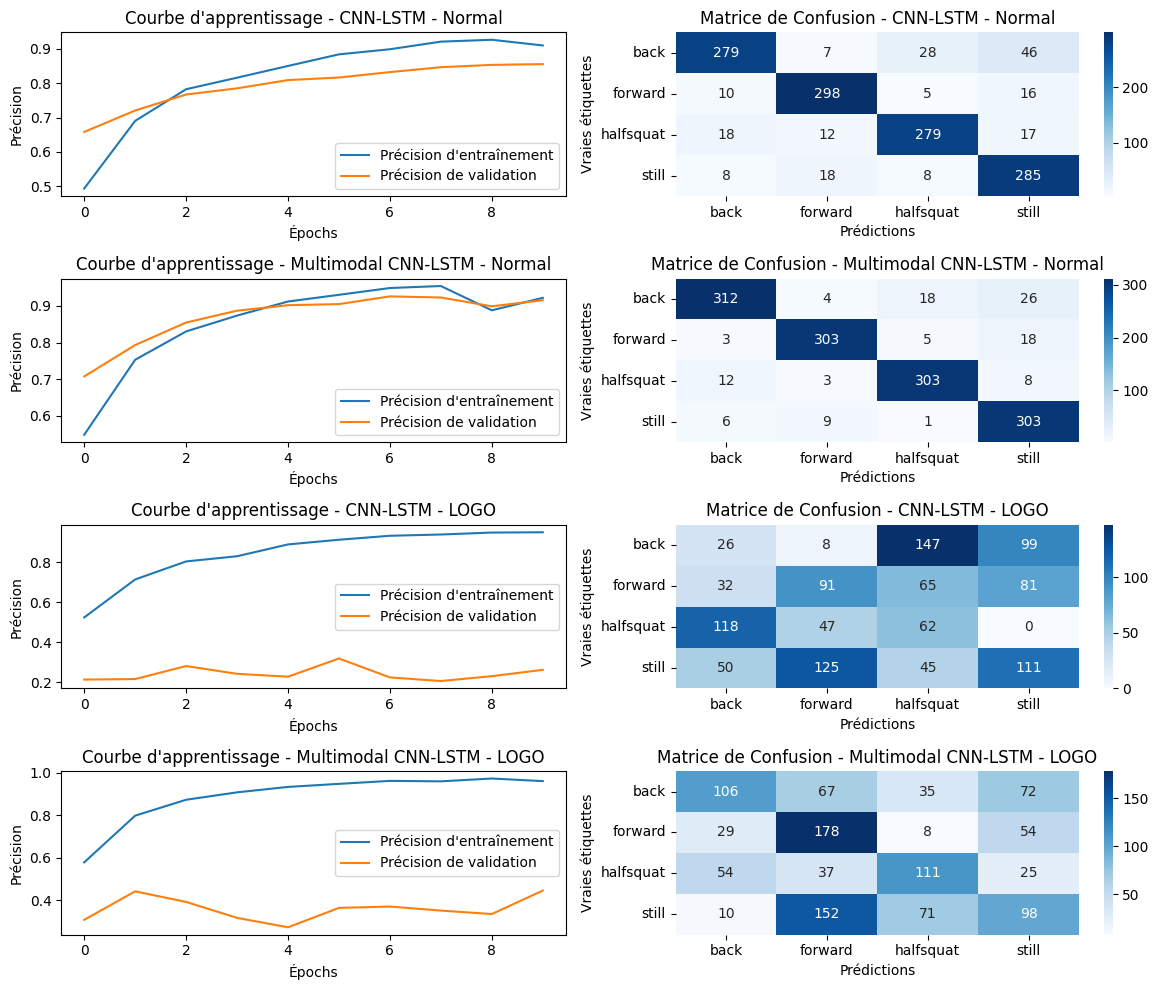

In [65]:
# ------------------------ Plotting Results ------------------------

# Courbes d'apprentissage pour les deux modèles
plt.figure(figsize=(12, 10))

# Courbes d'apprentissage - CNN-LSTM
plt.subplot(4, 2, 1)
plt.plot(history_cnn_lstm_normal.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm_normal.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - CNN-LSTM - Normal')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Matrice de confusion - CNN-LSTM
plt.subplot(4, 2, 2)
sns.heatmap(conf_matrix_cnn_lstm_normal, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion - CNN-LSTM - Normal')

# Courbes d'apprentissage - Multimodal CNN-LSTM
plt.subplot(4, 2, 3)
plt.plot(history_cnn_lstm_multimodal_normal.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm_multimodal_normal.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - Multimodal CNN-LSTM - Normal')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Matrice de confusion - Multimodal CNN-LSTM
plt.subplot(4, 2, 4)
sns.heatmap(conf_matrix_multimodal_normal, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion - Multimodal CNN-LSTM - Normal')

# ------------------------ Plotting Results ------------------------

# Courbes d'apprentissage - CNN-LSTM
plt.subplot(4, 2, 5)
plt.plot(history_cnn_lstm.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - CNN-LSTM - LOGO')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Matrice de confusion - CNN-LSTM
plt.subplot(4, 2, 6)
sns.heatmap(conf_matrix_cnn_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion - CNN-LSTM - LOGO')

# Courbes d'apprentissage - Multimodal CNN-LSTM
plt.subplot(4, 2, 7)
plt.plot(history_cnn_lstm_multimodal.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm_multimodal.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - Multimodal CNN-LSTM - LOGO')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Matrice de confusion - Multimodal CNN-LSTM
plt.subplot(4, 2, 8)
sns.heatmap(conf_matrix_multimodal, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion - Multimodal CNN-LSTM - LOGO')

# Ajustement pour éviter le chevauchement des titres et des étiquettes
plt.tight_layout()
plt.show()

In [75]:
print("Rapport de Classification - Multimodal CNN-LSTM - Normal :\n")
pd.DataFrame(report_multimodal_normal)

Rapport de Classification - Multimodal CNN-LSTM - Normal :



,back,forward,halfsquat,still,accuracy,macro avg,weighted avg
precision,0.936937,0.949843,0.926606,0.853521,0.915292,0.916727,0.917648
recall,0.866667,0.920973,0.929448,0.949843,0.915292,0.916733,0.915292
f1-score,0.900433,0.935185,0.928025,0.899110,0.915292,0.915688,0.915430
support,360.000000,329.000000,326.000000,319.000000,0.915292,1334.000000,1334.000000


In [76]:
print("Rapport de Classification - CNN-LSTM - Normal:\n")
pd.DataFrame(report_cnn_lstm_normal)

Rapport de Classification - CNN-LSTM - Normal:



,back,forward,halfsquat,still,accuracy,macro avg,weighted avg
precision,0.885714,0.889552,0.871875,0.782967,0.855322,0.857527,0.858709
recall,0.775000,0.905775,0.855828,0.893417,0.855322,0.857505,0.855322
f1-score,0.826667,0.897590,0.863777,0.834553,0.855322,0.855647,0.855113
support,360.000000,329.000000,326.000000,319.000000,0.855322,1334.000000,1334.000000


In [74]:

print("Rapport de Classification - Multimodal CNN-LSTM - LOGO :\n")

pd.DataFrame(report_multimodal)

Rapport de Classification - Multimodal CNN-LSTM - LOGO :



,back,forward,halfsquat,still,accuracy,macro avg,weighted avg
precision,0.532663,0.410138,0.493333,0.393574,0.445348,0.457427,0.453236
recall,0.378571,0.661710,0.488987,0.296073,0.445348,0.456335,0.445348
f1-score,0.442589,0.506401,0.491150,0.337931,0.445348,0.444518,0.436760
support,280.000000,269.000000,227.000000,331.000000,0.445348,1107.000000,1107.000000


In [ ]:
print("Rapport de Classification - CNN-LSTM - LOGO:\n")
pd.DataFrame(report_cnn_lstm)

Rapport de Classification - CNN-LSTM - LOGO:



,back,forward,halfsquat,still,accuracy,macro avg,weighted avg
precision,0.115044,0.335793,0.194357,0.381443,0.261969,0.256660,0.264605
recall,0.092857,0.338290,0.273128,0.335347,0.261969,0.259906,0.261969
f1-score,0.102767,0.337037,0.227106,0.356913,0.261969,0.255956,0.261183
support,280.000000,269.000000,227.000000,331.000000,0.261969,1107.000000,1107.000000


## Résultats
Les résultats montrent que :
- Le modèle multimodal surpasse le modèle simple dans les deux stratégies de validation
- La validation LOGO donne des résultats plus réalistes mais moins performants
- Les performances sont meilleures sur le split normal, suggérant une possible sur-adaptation aux patterns individuels

## Conclusion
Cette étude démontre l'intérêt d'une approche multimodale pour la classification d'exercices, tout en soulignant l'importance d'une validation rigoureuse pour évaluer la généralisation des modèles.